In [1]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [3]:
!pip install bert_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.6 MB/s eta 0:00:00


In [ ]:
# 구글 드라이브 마운트 필요시 사용
from google.colab import drive
drive.mount('/content/drive')

In [4]:
%cd /content
!git clone -b v1.0 https://github.com/camenduru/LLaVA
%cd /content/LLaVA
!pip install -q gradio .

from transformers import AutoTokenizer, BitsAndBytesConfig
from llava.model import LlavaLlamaForCausalLM
import torch

model_path = "4bit/llava-v1.5-13b-3GB"
kwargs = {"device_map": "auto"}
kwargs['load_in_4bit'] = True
kwargs['quantization_config'] = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type='nf4'
)
model = LlavaLlamaForCausalLM.from_pretrained(model_path, low_cpu_mem_usage=True, **kwargs)
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)

vision_tower = model.get_vision_tower()
if not vision_tower.is_loaded:
    vision_tower.load_model()
vision_tower.to(device='cuda')
image_processor = vision_tower.image_processor

import os
import requests
from PIL import Image
from io import BytesIO
from llava.conversation import conv_templates, SeparatorStyle
from llava.utils import disable_torch_init
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.mm_utils import tokenizer_image_token, get_model_name_from_path, KeywordsStoppingCriteria
from transformers import TextStreamer

def caption_image(image_file, prompt):
    if image_file.startswith('http') or image_file.startswith('https'):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(image_file).convert('RGB')
    disable_torch_init()
    conv_mode = "llava_v0"
    conv = conv_templates[conv_mode].copy()
    roles = conv.roles
    image_tensor = image_processor.preprocess(image, return_tensors='pt')['pixel_values'].half().cuda()
    inp = f"{roles[0]}: {prompt}"
    inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + inp
    conv.append_message(conv.roles[0], inp)
    conv.append_message(conv.roles[1], None)
    raw_prompt = conv.get_prompt()
    input_ids = tokenizer_image_token(raw_prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()
    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    keywords = [stop_str]
    stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)
    with torch.inference_mode():
      output_ids = model.generate(input_ids, images=image_tensor, do_sample=True, temperature=0.2,
                                  max_new_tokens=1024, use_cache=True, stopping_criteria=[stopping_criteria])
    outputs = tokenizer.decode(output_ids[0, input_ids.shape[1]:]).strip()
    conv.messages[-1][-1] = outputs
    output = outputs.rsplit('</s>', 1)[0]
    return image, output

/content
Cloning into 'LLaVA'...
remote: Enumerating objects: 1529, done.
remote: Counting objects: 100% (380/380), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 1529 (delta 345), reused 324 (delta 324), pack-reused 1149
Receiving objects: 100% (1529/1529), 13.21 MiB | 21.03 MiB/s, done.
Resolving deltas: 100% (919/919), done.
/content/LLaVA
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.7/302.7 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 10.5 MB/s eta 0:00:00
     ━━

config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/33.7k [00:00<?, ?B/s]

pytorch_model-00001-of-00009.bin:   0%|          | 0.00/2.97G [00:00<?, ?B/s]

pytorch_model-00002-of-00009.bin:   0%|          | 0.00/2.93G [00:00<?, ?B/s]

pytorch_model-00003-of-00009.bin:   0%|          | 0.00/2.89G [00:00<?, ?B/s]

pytorch_model-00004-of-00009.bin:   0%|          | 0.00/2.96G [00:00<?, ?B/s]

pytorch_model-00005-of-00009.bin:   0%|          | 0.00/2.89G [00:00<?, ?B/s]

pytorch_model-00006-of-00009.bin:   0%|          | 0.00/2.98G [00:00<?, ?B/s]

pytorch_model-00007-of-00009.bin:   0%|          | 0.00/2.87G [00:00<?, ?B/s]

pytorch_model-00008-of-00009.bin:   0%|          | 0.00/2.89G [00:00<?, ?B/s]

pytorch_model-00009-of-00009.bin:   0%|          | 0.00/2.72G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.76k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/9 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/154 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

In [5]:
from PIL import Image
import matplotlib.pyplot as plt

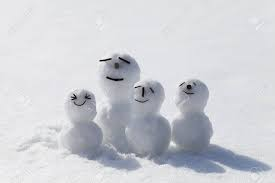

The unusual aspect of this image is that the snowman and snowwoman are smiling, which is not a common feature in snow sculptures.


In [7]:
path = "/content/snowfamily.jpg"

image = Image.open(path).convert("RGB")
display(image)

image, output = caption_image(path, 'What is unusual about this image? Answer short.')
print(output)

In [6]:
import pandas as pd
import numpy as np
import json
import csv

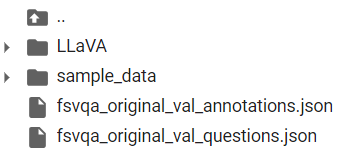

In [7]:
with open('/content/fsvqa_original_val_questions.json') as json_file:
    json_data = json.load(json_file)

In [107]:
N = 10

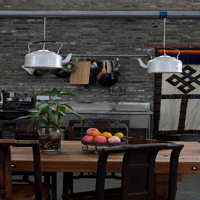

The table is made of wood.


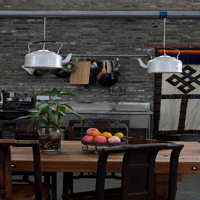

No, the food is not napping on the table. The table has a bowl of fruit, including apples and oranges.


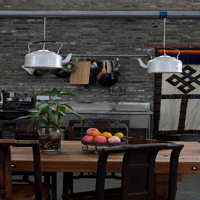

Tea kettles have been upcycled to make lights in this kitchen.


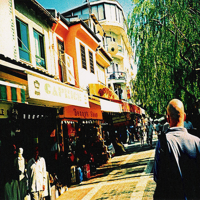

Yes, this is a Spanish town with a narrow street lined with shops and people walking around.


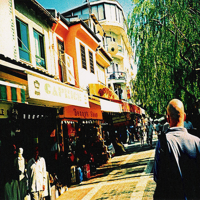

Yes, there are shadows on the sidewalk.


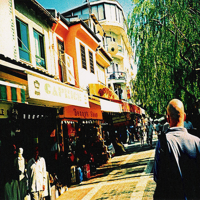

A balcony on a building.


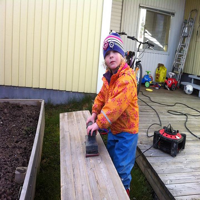

Yes


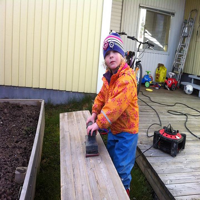

A bicycle is leaning against the house.


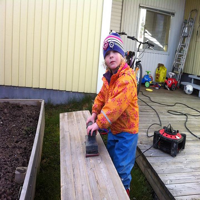

1


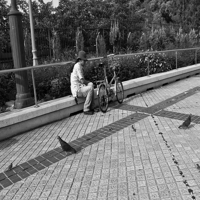

Yes, this is in a park.


In [108]:
import io
import requests

answer = []
for j in range(N):
    s = str(json_data['questions'][j]['img_id'])
    while len(s)<12:
      s = "0"+s
    url = f"http://images.cocodataset.org/train2017/"+s+".jpg"
    image, output = caption_image(url, json_data['questions'][j]['question']+"Answer in one full sentence.")
    display(image.resize((200,200)))
    print(output)
    answer.append(output)

In [109]:

with open("/content/fsvqa_original_val_annotations.json") as json_file:
    answer_data = json.load(json_file)
ref = []
for a in range(N):
    ref.append(answer_data['annotations'][a]['answers'][0]['answer'])

In [110]:
from bert_score import score

P, R, F1 = score(answer, ref, lang="en", verbose=True)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.16 seconds, 61.59 sentences/sec


In [111]:
print(f"System level F1 score: {F1.mean():.3f}")

System level F1 score: 0.924


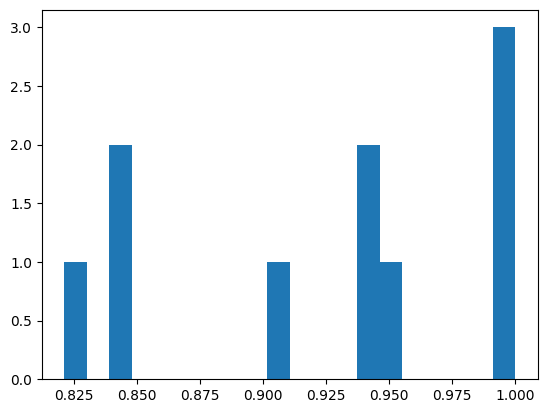

In [112]:
import matplotlib.pyplot as plt
plt.hist(F1, bins=20)
plt.show()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


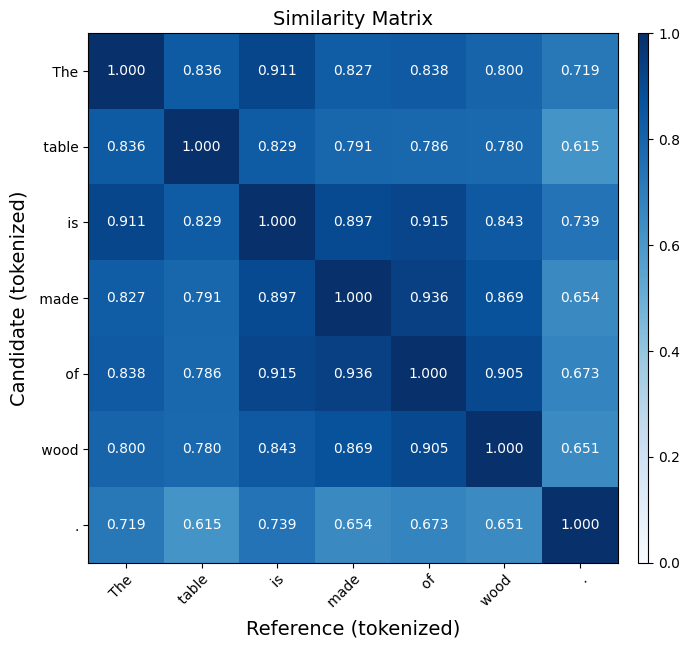

In [114]:
from bert_score import plot_example

A = answer[0]
R = ref[0]
plot_example(A, R, lang="en")